In [1]:
using Distributed
addprocs(44);

### Fitting a choice model.

First you have to include the necessary package

In [2]:
using PulseInputDDM, Flatten

### Geneerate some data
Blah blah blah

In [3]:
θ_syn = θchoice(θz=θz(σ2_i = 1., B = 13., λ = -0.5, σ2_a = 10., σ2_s = 1.0,
    ϕ = 0.4, τ_ϕ = 0.02), bias=0.1, lapse=0.1);

In [4]:
xgen = collect(Flatten.flatten(θ_syn));

In [5]:
_, data = synthetic_data(;θ=θ_syn, ntrials=20_000, rng=1, dt=1e-2);

In [6]:
n = 53

53

In [7]:
model = choiceDDM(θ=θ_syn, data=data, n=n);

In [8]:
loglikelihood(model)

-7480.922581827128

In [9]:
x0 = vcat([0.1, 15., -0.1, 20., 0.5, 0.2, 0.008], [0.,0.01]); #random initial state

In [10]:
θ = Flatten.reconstruct(θchoice(), x0)

θchoice{θz{Float64}, Float64}
  θz: θz{Float64}
  bias: Float64 0.0
  lapse: Float64 0.01


In [11]:
model = choiceDDM(θ=θ, data=data, n=n);

In [12]:
loglikelihood(model)

-8783.722335396948

In [13]:
options = choiceoptions()

choiceoptions
  fit: Array{Bool}((9,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((9,)) [0.0, 4.0, -5.0, 0.0, 0.0, 0.01, 0.005, -5.0, 0.0]
  ub: Array{Float64}((9,)) [30.0, 30.0, 5.0, 100.0, 2.5, 1.2, 1.0, 5.0, 1.0]


### Optimize stuff
Blah blah blah

In [14]:
model, = optimize(model, options, f_tol=1e-12)

Fminbox
-------
Initial mu = 0.396341

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.396341

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     8.790486e+03     1.277078e+05
 * time: 0.03212785720825195
    10     7.483916e+03     1.584157e+03
 * time: 112.40252184867859
    20     7.479882e+03     1.443157e+02
 * time: 202.04963493347168
    30     7.479690e+03     2.722511e+01
 * time: 293.0238468647003
    40     7.479663e+03     3.482095e+00
 * time: 386.31152391433716
    50     7.479663e+03     2.536669e+00
 * time: 529.6162269115448

Exiting inner optimizer with x = [8.758171255390243, 9.929634006402594, -0.657803717642161, 15.106766768320265, 0.6015775921004641, 0.5028012613313838, 0.025106138066745352, 0.10296987537085114, 0.08919730653492829]
Current distance to box: 0.0201061
Decreasing barrier term μ.

Fminbox iteration 2
-------------------
Calling inner optimizer with mu = 0.000396341

(numbers be

(choiceDDM{θchoice{θz{Float64}, Float64}, Vector{PulseInputDDM.choicedata{PulseInputDDM.choiceinputs{PulseInputDDM.clicks, PulseInputDDM.binned_clicks}}}, θprior{Float64}}
  θ: θchoice{θz{Float64}, Float64}
  data: Array{PulseInputDDM.choicedata{PulseInputDDM.choiceinputs{PulseInputDDM.clicks, PulseInputDDM.binned_clicks}}}((20000,))
  n: Int64 53
  cross: Bool false
  θprior: θprior{Float64}
,  * Status: success

 * Candidate solution
    Final objective value:     7.486067e+03

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 9.79e-08 ≰ 1.0e-10
    |x - x'|/|x'|          = 5.18e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-12
    |g(x)|                 = 2.74e-03 ≰ 1.0e-03

 * Work counters
    Seconds run:   1235  (vs limit 170000)
    Iterations:    4
    f(x) calls:    220
    ∇f(x) calls:   107
)

In [15]:
loglikelihood(model)

-7476.163209942431

### Compute Hessian
Blah blah blah

In [16]:
gradient(model)

9-element Vector{Float64}:
  1.515048520628337e-5
  0.00018799498836619133
  5.801660330817526e-6
 -9.712130112249362e-6
  0.00020367244697361286
  0.0012082080600208656
  0.0027380002235304346
 -1.1891274864783696e-6
  0.0014880339709577584

In [17]:
H = Hessian(model)
CI, HPSD = CIs(H);

In [18]:
using LinearAlgebra
eigvals(H)

9-element Vector{Float64}:
     0.008394116425879674
     0.037046035234315745
     0.24377112900926542
    21.725323008838966
    78.14397353323193
   166.42114921239153
   230.17235099745912
 37074.2061175062
     1.314365792005779e6

In [19]:
CI

9-element Vector{Float64}:
 10.324975416655946
  4.262537962562378
  0.5705316490141428
 21.803695063357726
  0.799434215721121
  0.1377196120122238
  0.010010928137233395
  0.15590877197959496
  0.015335828930732192

In [20]:
xf = collect(Flatten.flatten(model.θ))

9-element Vector{Float64}:
  8.221811645997633
  9.722736964595201
 -0.6746515317042434
 13.957143697604316
  0.6357282931780418
  0.49639861340169505
  0.024902133661102537
  0.10294903895958779
  0.08946266347465955

In [21]:
(xf - CI) .< xgen

9-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [22]:
(xf + CI) .> xgen

9-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [23]:
hcat(xf, xgen)

9×2 Matrix{Float64}:
  8.22181     1.0
  9.72274    13.0
 -0.674652   -0.5
 13.9571     10.0
  0.635728    1.0
  0.496399    0.4
  0.0249021   0.02
  0.102949    0.1
  0.0894627   0.1

In [24]:
lb = options.lb

9-element Vector{Float64}:
  0.0
  4.0
 -5.0
  0.0
  0.0
  0.01
  0.005
 -5.0
  0.0

In [25]:
ub = options.ub

9-element Vector{Float64}:
  30.0
  30.0
   5.0
 100.0
   2.5
   1.2
   1.0
   5.0
   1.0

In [26]:
@everywhere ℓℓ(x, model) = -PulseInputDDM.loglikelihood(x, model)

In [27]:
αs = hcat(map((lb,ub)-> range(lb + eps(), stop=ub, length=30), lb, ub))

9×1 Matrix{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}:
 2.220446049250313e-16:1.0344827586206897:30.0
 4.0:0.896551724137931:30.0
 -5.0:0.3448275862068966:5.0
 2.220446049250313e-16:3.4482758620689653:100.0
 2.220446049250313e-16:0.08620689655172413:2.5
 0.010000000000000222:0.04103448275862068:1.2
 0.005000000000000222:0.0343103448275862:1.0
 -5.0:0.3448275862068966:5.0
 2.220446049250313e-16:0.03448275862068965:1.0

In [28]:
LL_scan = map(i-> map(x-> ℓℓ(vcat(xf[1:i-1], x, xf[i+1:end]), model), αs[i]), 1:9);

In [29]:
using PyPlot

In [30]:
xf[1] - CI[1], lb[1]

(-2.1031637706583126, 0.0)

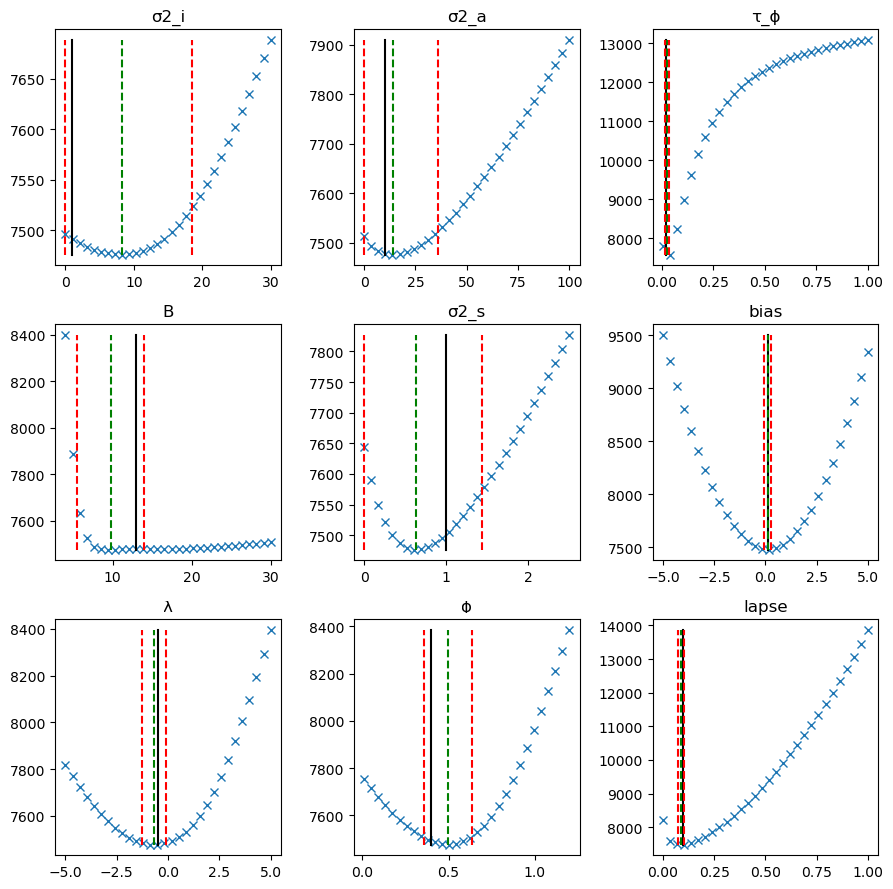

In [31]:
num_rows, num_cols = 3,3
fig, ax = subplots(num_rows, num_cols, figsize=(9,9))
name = ["σ2_i", "B", "λ", "σ2_a", "σ2_s", "ϕ", "τ_ϕ", "bias", "lapse"]

for i in 1:9
                  
    ax[i].plot(αs[i], LL_scan[i], "x")
    ax[i].set_title(name[i])
    ax[i].plot(xgen[i]*ones(100), range(minimum(LL_scan[i]), stop=maximum(LL_scan[i]), length=100), "k")
    ax[i].plot(xf[i]*ones(100), range(minimum(LL_scan[i]), stop=maximum(LL_scan[i]), length=100),
        "g--")
    ax[i].plot(max((xf[i] - CI[i]), lb[i]) *ones(100), range(minimum(LL_scan[i]), 
            stop=maximum(LL_scan[i]), length=100), "r--")
    ax[i].plot(min((xf[i] + CI[i]), ub[i]) *ones(100), range(minimum(LL_scan[i]), 
            stop=maximum(LL_scan[i]), length=100), "r--")

    
end

tight_layout() 

## Saving and reloading modeling results

In [32]:
save_file = "../choice model/example_results.mat"
save_choice_model(save_file, model, options, CI)

In [33]:
#if you've already ran the optimization once and want to restart from where you stoped, this will reload those parameters
θ, options = reload_choice_model(save_file)

(θchoice{θz{Float64}, Float64}
  θz: θz{Float64}
  bias: Float64 0.10294903895958779
  lapse: Float64 0.08946266347465955
, choiceoptions
  fit: Array{Bool}((9,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((9,)) [0.0, 4.0, -5.0, 0.0, 0.0, 0.01, 0.005, -5.0, 0.0]
  ub: Array{Float64}((9,)) [30.0, 30.0, 5.0, 100.0, 2.5, 1.2, 1.0, 5.0, 1.0]
)

In [34]:
model = choiceDDM(θ=θ, data=data, n=n);
loglikelihood(model)

-7476.163209942431

## Saving choice data

In [35]:
PulseInputDDM.save_choice_data("../choice model/example_matfile_2.mat", data)

In [36]:
data = load_choice_data("../choice model/example_matfile_2.mat");

In [37]:
model = choiceDDM(θ=θ, data=data, n=n);
loglikelihood(model)

-7476.163209942431

## Loading data and fitting a choice model

The package expects your data to live in a single .mat file which should contain a struct called `rawdata`. Each element of `rawdata` should have data for one behavioral trial and `rawdata` should contain the following fields with the specified structure:

 - `rawdata.leftbups`: row-vector containing the relative timing, in seconds, of left clicks on an individual trial. 0 seconds is the start of the click stimulus.
 - `rawdata.rightbups`: row-vector containing the relative timing in seconds (origin at 0 sec) of right clicks on an individual trial. 0 seconds is the start of the click stimulus.
 - `rawdata.T`: the duration of the trial, in seconds. The beginning of a trial is defined as the start of the click stimulus. The end of a trial is defined based on the behavioral event “cpoke_end”. This was the Hanks convention.
 - `rawdata.pokedR`: `Bool` representing the animal choice (1 = right).

In [143]:
data = load_choice_data("../choice model/example_matfile.mat");

## Fitting the model

Once your data is correctly formatted and you have the package added in julia, you are ready to fit the model. You need to write a slurm script to use spock's resources and a .jl file to load the data and fit the model. See examples of each below. These files are also located in the package in the `examples` directory.

### Example slurm script

This will start a job called `fit_choice_model`. Output will be written to a log file called `fit_choice_model.out`. This will run on the `Brody` partition of spock for 12 hours, using 44 cores and 64 GB of memory. You'll notice that we load the julia module (like we did when we added the package) and then we call julia (`-p 44` uses the 44 cores) and ask it to run the .jl file.

```
 #!/usr/bin/env bash

 #SBATCH -J 'fit_choice_model'
 #SBATCH -o ../logs/fit_choice_model.out
 #SBATCH -p Brody
 #SBATCH --time=12:00:00
 #SBATCH --mem=64000
 #SBATCH -c 44

 module load julia/1.0.0
 julia -p 44 ./fit_choice_model.jl
 ```